## Mapping Social Vulnerability in Kathmandu

After working to extract our datasets in the last 3 labs, we now seek to combine all of them to create a map of social vulnerability. First, let us call all our datasets.

In [29]:
import geopandas as gpd

wealth = gpd.read_file("maincity.geojson")
wealth.head()

,OBJECTID,State,State_Code,District,Protected,Mun_Name,Mun_Type,Center,Area_SQKM,Ward_No,...,quart5_count,quart1_%,quart2_%,quart3_%,quart4_%,quart5_%,Municipality_y,streetcount,streetdensity,geometry
0,3708,Bagmati,3,KATHMANDU,None,Gokarneshwor,Nagarpalika,Gokarneshwor Municipality,4.6919,4,...,2354,0.19,3.41,10.87,35.97,49.57,Gokarneshwor,490,104.435303,"POLYGON ((85.40519 27.73718, 85.40503 27.73688..."
1,3709,Bagmati,3,KATHMANDU,None,Gokarneshwor,Nagarpalika,Gokarneshwor Municipality,1.0760,5,...,3255,0.01,0.64,7.88,42.81,48.65,Gokarneshwor,579,538.104089,"POLYGON ((85.37866 27.71699, 85.37832 27.71748..."
2,3710,Bagmati,3,KATHMANDU,None,Gokarneshwor,Nagarpalika,Gokarneshwor Municipality,0.5591,6,...,3581,0.03,0.41,7.52,46.54,45.51,Gokarneshwor,212,379.180826,"POLYGON ((85.38232 27.72444, 85.38237 27.7243,..."
3,3711,Bagmati,3,KATHMANDU,None,Gokarneshwor,Nagarpalika,Gokarneshwor Municipality,1.3092,8,...,4248,0.01,0.82,8.60,42.24,48.33,Gokarneshwor,622,475.099297,"POLYGON ((85.38573 27.7329, 85.38584 27.7328, ..."
4,3712,Bagmati,3,KATHMANDU,None,Gokarneshwor,Nagarpalika,Gokarneshwor Municipality,1.2049,9,...,872,0.00,2.81,17.05,45.07,35.06,Gokarneshwor,496,411.652419,"POLYGON ((85.38573 27.7329, 85.38539 27.73287,..."


In [30]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize


with rasterio.open("data/predictions/built_up_prediction_2025.tif") as src:
    built_up = src.read(1)
    # Save metadata for later use (this will be our reference for alignment)
    reference_meta = src.meta.copy()
    reference_transform = src.transform
    reference_crs = src.crs
    reference_shape = built_up.shape


The various datasets we are using are not aligned together. The following function will take in a reference raster and align other datasets to it. It will also clip and mask the datasets.

In [31]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import geometry_mask

def align_and_clip_raster(src_path, reference_meta, boundary_path):
    # Load boundary
    boundary = gpd.read_file(boundary_path)
    
    with rasterio.open(src_path) as src:
        # Ensure boundary is in the same CRS as the reference
        if boundary.crs != reference_meta['crs']:
            boundary = boundary.to_crs(reference_meta['crs'])
            print(f"Reprojected boundary from {boundary.crs} to {reference_meta['crs']}")
        
        # Check if alignment is needed
        alignment_needed = (src.crs != reference_meta['crs'] or 
                            src.transform != reference_meta['transform'] or 
                            src.width != reference_meta['width'] or 
                            src.height != reference_meta['height'])
        
        if alignment_needed:
            # Prepare output raster
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs, reference_meta['crs'],
                src.width, src.height,
                *src.bounds,
                dst_width=reference_meta['width'],
                dst_height=reference_meta['height']
            )
            
            dst_kwargs = reference_meta.copy()
            dst_kwargs.update({
                'crs': reference_meta['crs'],
                'transform': dst_transform,
                'width': dst_width,
                'height': dst_height
            })
            
            # Load and reproject the data
            destination = np.zeros((1, dst_height, dst_width), dtype=np.float32)
            
            reproject(
                source=rasterio.band(src, 1),
                destination=destination[0],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=reference_meta['crs'],
                resampling=Resampling.nearest
            )
            
            # Aligned data is now in destination
            aligned_data = destination[0]
        else:
            print(f"{src_path} is already aligned with reference")
            aligned_data = src.read(1)
        
        # Create a mask from the boundary
        mask_array = geometry_mask(
            geometries=boundary.geometry,
            out_shape=(reference_meta['height'], reference_meta['width']),
            transform=reference_meta['transform'],
            all_touched=True,
            invert=True  # Invert to mask outside the boundary
        )
        
        # Apply the mask to the aligned data
        clipped_data = aligned_data.copy()
        clipped_data[~mask_array] = reference_meta.get('nodata', -9999)
        
        return clipped_data

Now, we align our datasets.

In [32]:
ndvi = align_and_clip_raster("data/predictions/ndvi_2025.tif", reference_meta, "maincity.geojson")

inundation = align_and_clip_raster("data/dem/inundation_depths.tif", reference_meta, "maincity.geojson")

Reprojected boundary from PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]] to EPSG:32645
data/predictions/ndvi_2025.tif is already aligned with reference
Reprojected boundary from PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY

Now, we need to process our wealth dataset. Here, we are turning percentage of people in each economic quartile into a normalized scale.

In [33]:
# Higher values = higher vulnerability (more poor households)
wealth['vulnerability_index'] = (
    wealth['quart1_%'] * 1.0 + 
    wealth['quart2_%'] * 0.75 + 
    wealth['quart3_%'] * 0.5 + 
    wealth['quart4_%'] * 0.25 + 
    wealth['quart5_%'] * 0  # wealthiest quintile contributes 0 to vulnerability
) / 100  # Convert from percentage to 0-1 scale

# Ensure wealth data is in the same CRS as our reference
if wealth.crs != reference_crs:
    wealth = wealth.to_crs(reference_crs)

Now, we will rasterize our geojson data so that we can use it in our vulnerability map.

In [ ]:
wealth_raster = rasterize(
    [(geometry, value) for geometry, value in zip(wealth.geometry, wealth['vulnerability_index'])],
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0, 
    dtype=np.float32
)

# Save the wealth raster
with rasterio.open('data/wealth_raster.tif', 'w', 
                  driver='GTiff', 
                  height=reference_shape[0], 
                  width=reference_shape[1], 
                  count=1, 
                  dtype=wealth_raster.dtype, 
                  crs=reference_crs, 
                  transform=reference_transform) as dst:
    dst.write(wealth_raster, 1)

Now that all of our data is loaded, we will normalize them on a 0-1 scale so that they can be combined. For this, we will create a function.

In [35]:
def normalize(array, inverse=False):
    array_min = np.nanmin(array)
    array_max = np.nanmax(array)
    
    if array_max == array_min:
        return np.ones_like(array) * 0.5  # Return mid-value if array is constant
    
    normalized = (array - array_min) / (array_max - array_min)
    
    if inverse:
        return 1 - normalized
    return normalized

Now, we normalize everything.

In [36]:
built_up= normalize(built_up)

ndvi = normalize(ndvi, inverse=True)

# Handle potential negative values or NaN in inundation data
inundation[inundation < 0] = 0  # Set negative values to 0
inundation = normalize(inundation)

We need to mask our dataset again so that it doesn't contain values from outside the study area.

In [37]:
from rasterio import features
from rasterio.transform import from_origin


height, width = built_up.shape

xmin, ymin, xmax, ymax = wealth.total_bounds
resolution = (xmax - xmin) / width 
transform = from_origin(xmin, ymax, resolution, resolution)

# Create an empty mask raster
mask = np.zeros((height, width), dtype=np.uint8)

# Rasterize the wealth
shapes = [(geom, 1) for geom in wealth.geometry]
rasterized = features.rasterize(shapes, out_shape=mask.shape, 
                               fill=0, transform=transform, 
                               dtype=np.uint8)

# Convert to boolean mask
wealth_mask = rasterized.astype(bool)

built_up = np.ma.masked_array(built_up, mask=~wealth_mask)
ndvi = np.ma.masked_array(ndvi, mask=~wealth_mask)
inundation = np.ma.masked_array(inundation, mask=~wealth_mask)
wealth = np.ma.masked_array(wealth_raster, mask=~wealth_mask)

Let us see how our various maps look like by plotting them.

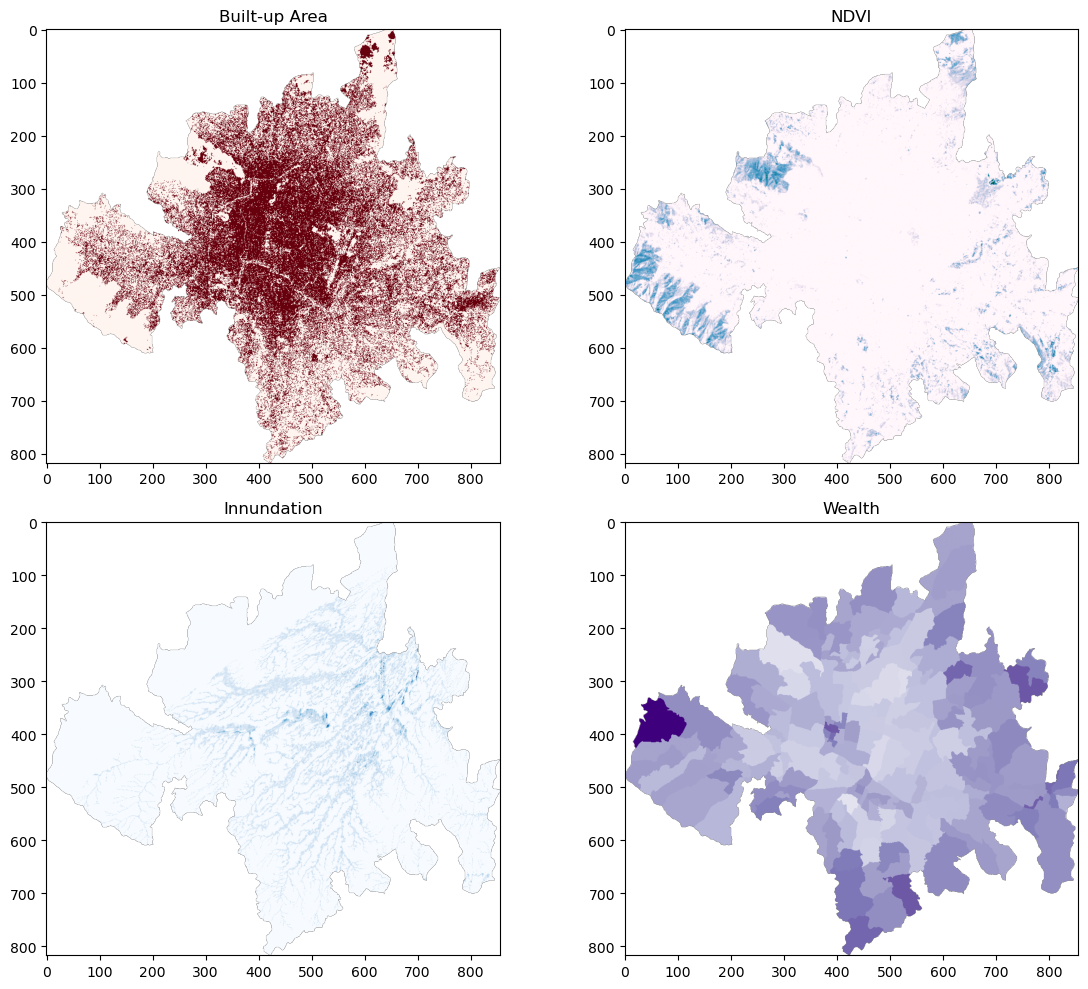

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))


axs[0, 0].imshow(built_up, cmap='Reds')
axs[0, 0].set_title('Built-up Area')

axs[0, 1].imshow(ndvi, cmap='PuBuGn')
axs[0, 1].set_title('NDVI')

axs[1, 0].imshow(inundation, cmap='Blues')
axs[1, 0].set_title('Innundation')

axs[1, 1].imshow(wealth, cmap='Purples')
axs[1, 1].set_title('Wealth')

plt.tight_layout()
plt.show()

Great, now we can combine our dataset. First let us select the weights of each dataset. We are using roughly equal weights for each of them.

In [39]:
weights = {
    'built_up': 0.2,  # Built-up Density
    'ndvi': 0.2,      # Inverse NDVI 
    'inundation': 0.3, # Flood vulnerability 
    'wealth': 0.3     # Income Density
}

In [40]:
# Handle potential NaN values in any layer
built_up = np.nan_to_num(built_up, nan=0)
ndvi = np.nan_to_num(ndvi, nan=0)
inundation = np.nan_to_num(inundation, nan=0)
wealth_raster = np.nan_to_num(wealth_raster, nan=0)

In [41]:
vulnerability = (
    weights['built_up'] * built_up +
    weights['ndvi'] * ndvi +
    weights['inundation'] * inundation +
    weights['wealth'] * wealth_raster
)

Finally, we will plot the results.

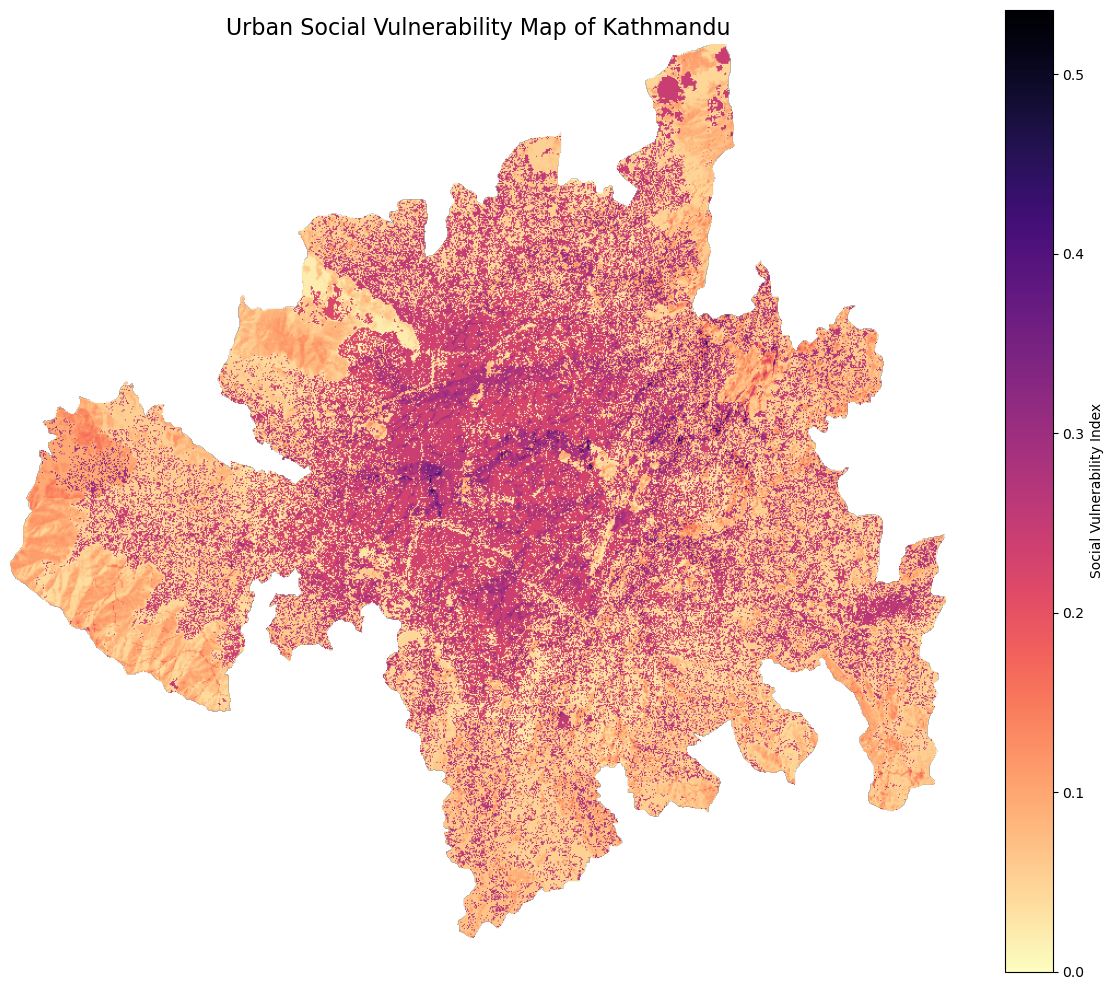

In [47]:
plt.figure(figsize=(12, 10))

im = plt.imshow(vulnerability, cmap="magma_r")
plt.colorbar(im, label='Social Vulnerability Index')
plt.title('Urban Social Vulnerability Map of Kathmandu', size=16)
plt.axis('off') 
plt.tight_layout()
plt.show()

Finally, let us plot our data over a folum map so that we can see how it looks like in the context of Kathmandu. To do that, we first need to remove the mask from our raster and then apply a color palette to it.

In [57]:
import folium
from folium import raster_layers
import matplotlib.pyplot as plt
import numpy as np

# Convert the masked array to a regular array for plotting
vulnerability_folium = np.ma.filled(vulnerability, np.nan)

# Handle potential zero division and normalize the data
vmin = np.nanmin(vulnerability_folium)
vmax = np.nanmax(vulnerability_folium)

if vmax != vmin and not np.isnan(vmin) and not np.isnan(vmax):
    vulnerability_normalized = (vulnerability_folium - vmin) / (vmax - vmin)
    vulnerability_folium = (255 * vulnerability_normalized).astype(np.uint8)
else:
    # Handle case where all values are the same
    vulnerability_folium = np.zeros_like(vulnerability_folium, dtype=np.uint8)

# Apply the colormap
colormap = plt.colormaps.get_cmap('magma_r')
vulnerability_colored = colormap(vulnerability_folium / 255.0)

/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_31627/1944020993.py:15: RuntimeWarning: invalid value encountered in cast
  vulnerability_folium = (255 * vulnerability_normalized).astype(np.uint8)



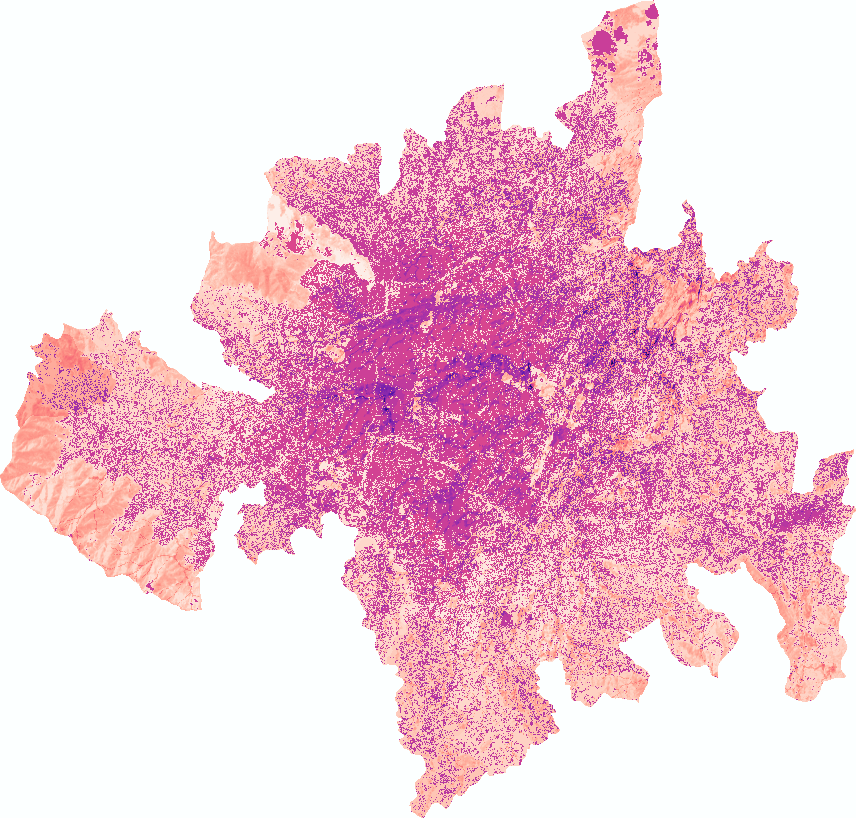

In [58]:
m = folium.Map(location=[27.7, 85.3], zoom_start=12)

bounds = gpd.read_file("maincity.geojson").total_bounds
lat_min, lat_max = bounds[1], bounds[3]
lon_min, lon_max = bounds[0], bounds[2]

folium.raster_layers.ImageOverlay(
    image=vulnerability_colored,
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    opacity=0.7,
    interactive=False,
    cross_origin=False,
    zindex=1
).add_to(m)

m